In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import argparse 

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Setup Datasets + Models

In [7]:
models_by_size = {}

for model_size in [2,5,10,15]:
    num_objects = 1
    noisy=False
    weight_decay = 0.0004
    encoder_model='mlp_{}_1'.format(model_size)
    optimizer = 'sgd'
    seed = 42

    models_by_size[model_size] = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

In [8]:
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy,encoder_model=encoder_model)
val_images, val_y, val_c = unroll_data(val_loader)

## Adversarial Results

In [10]:
activation_values = {}
ret_images = {}

for model_size in models_by_size:
    activation_values[model_size] = []
    ret_images[model_size] = []

    for concept_num in range(num_objects*2):
        ret_image = get_maximal_activation(models_by_size[model_size],run_joint_model,concept_num,
                                        get_valid_image_function(concept_num,num_objects,epsilon=32))
        activation_values[model_size].append (
            torch.nn.Sigmoid()(run_joint_model(models_by_size[model_size],ret_image)[1])[concept_num][0].detach().numpy()
        )

        ret_image = ret_image.detach()[0].numpy()
        ret_images[model_size].append(ret_image)


In [11]:
for i in activation_values:
    activation_values[i] = np.array(activation_values[i]).tolist()

In [12]:
json.dump(activation_values, open('results/synthetic/mlp_results.json','w'))

In [13]:
def random_right(img):
    img = deepcopy(img)
    img[0,:,128:] = ((torch.rand(1,256,128) < 0.5).long()-0.5)/2
    img[1,:,128:] = img[0,:,128:]
    img[2,:,128:] = 0.25

    return img

In [14]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

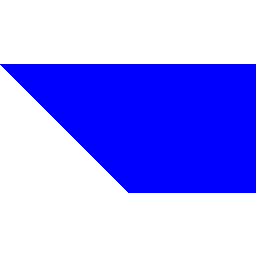

In [15]:
numpy_to_pil(val_images[0].detach().numpy())

In [16]:
dataset = torch.stack([random_right(val_images[0]) for i in range(20)])

In [17]:
for model_size in models_by_size:
    y,c = run_joint_model(models_by_size[model_size],dataset)
    print(torch.argmax(c.T,dim=1))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


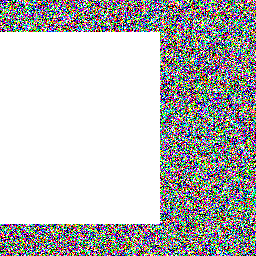

In [18]:
numpy_to_pil(ret_images[2][0])

## Analyzing Weights

In [19]:
model_size = 10

In [20]:
clean_image_0 = val_images[torch.where(val_c == torch.Tensor([1,0]))[0][0]]
clean_image_1 = val_images[torch.where(val_c == torch.Tensor([0,1]))[0][0]]


In [21]:
adversarial_image_0 = torch.Tensor(ret_images[model_size][0])
adversarial_image_1 = torch.Tensor(ret_images[model_size][1])

In [22]:
all_inputs = torch.stack([clean_image_0,adversarial_image_0,clean_image_1,adversarial_image_1])

In [23]:
torch.argmax(run_joint_model(models_by_size[model_size],all_inputs)[1].T,dim=1)

tensor([0, 0, 1, 0])

In [24]:
all_inputs.shape

torch.Size([4, 3, 256, 256])

In [25]:
first_results = models_by_size[model_size].first_model.linear(all_inputs.reshape(4,3*256*256))

In [26]:
np.set_printoptions(suppress=True)
np.round(first_results.detach().numpy(),2)

array([[ 91.57,  -0.13,  21.24,  -0.2 ,  -2.92, -10.93,  -0.02,  -0.04,
         -4.23,  23.28],
       [404.31,  21.43,  64.81,  69.77,  -8.17, -31.71,  -0.04,  13.95,
          0.5 ,  -0.11],
       [ 19.28,  -0.05,  -4.98,  -0.14,  -7.96, -14.03,  -0.1 ,  -0.14,
        -10.78,  78.11],
       [-13.24,  27.37,  -4.  ,  -0.29,  -0.09,  -0.35,  -0.27,  -0.3 ,
         -0.32, -45.8 ]], dtype=float32)

In [27]:
activated_first_results = models_by_size[model_size].first_model.activation(first_results)

In [28]:
linear_2_weights = models_by_size[model_size].first_model.linear2.weight
linear_2_weights.shape

torch.Size([2, 10])

In [29]:
product_0 = linear_2_weights[0]*activated_first_results
product_1 = linear_2_weights[1]*activated_first_results 

In [30]:
product_0[0]

tensor([ 58.4614,   0.0000,   2.0324,   0.0000,   0.0000,  -0.0000,  -0.0000,
          0.0000,   0.0000, -12.8319], grad_fn=<SelectBackward0>)

In [31]:
product_0[1]

tensor([2.5812e+02, 1.4486e+00, 6.2027e+00, 1.4549e+01, 0.0000e+00, -0.0000e+00,
        -0.0000e+00, 5.7849e-01, 2.3277e-02, -0.0000e+00],
       grad_fn=<SelectBackward0>)

In [32]:
product_1[2]

tensor([-7.0815,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
        -0.0000, 91.4672], grad_fn=<SelectBackward0>)

In [33]:
product_1[3]

tensor([-0.0000, 0.3963, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000,
        0.0000], grad_fn=<SelectBackward0>)

In [34]:
adversarial_0_max = torch.argmax(product_0[1])
adversarial_1_max = torch.argmax(product_1[3])
adversarial_0_max, adversarial_1_max

(tensor(0), tensor(1))

In [35]:
torch.sum(product_0,dim=1), torch.sum(product_1,dim=1)

(tensor([ 47.6619, 280.9175, -30.7392,   1.8494], grad_fn=<SumBackward1>),
 tensor([ -13.8174, -171.5791,   84.3857,    0.3963], grad_fn=<SumBackward1>))

## Maximizers by Weight

In [36]:
linear_1_weights = models_by_size[model_size].first_model.linear.weight.reshape((model_size,3,256,256))
linear_1_weights = ((linear_1_weights>0).long()-0.5)/2
linear_1_weights.shape

torch.Size([10, 3, 256, 256])

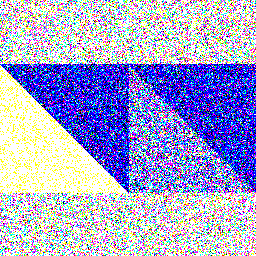

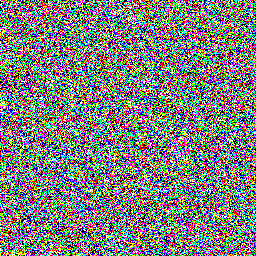

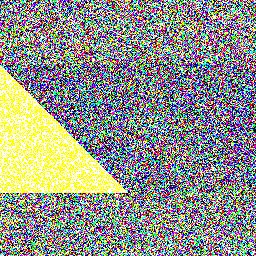

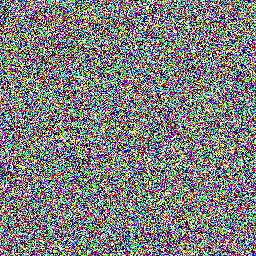

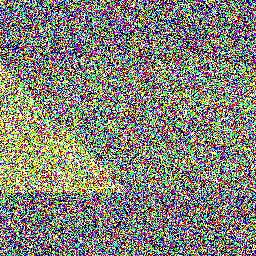

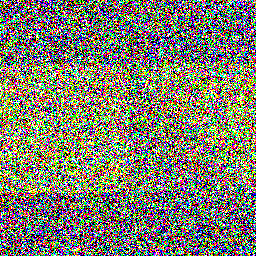

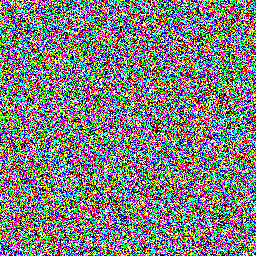

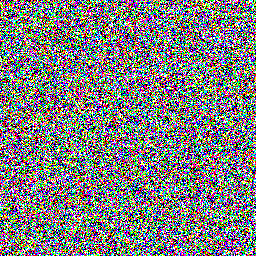

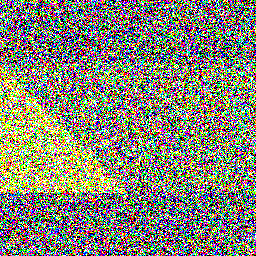

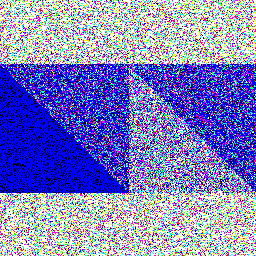

IndexError: index 10 is out of bounds for dimension 0 with size 10

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [126]:
for i in range(model_size):
    pil_image = numpy_to_pil(linear_1_weights[i].detach().numpy())
    display(pil_image)
    pil_image.save('results/synthetic/mlp_filter_{}.png'.format(i))
    plt.figure()


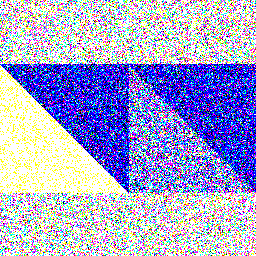

In [38]:
pil_image = numpy_to_pil(linear_1_weights[adversarial_0_max].detach().numpy())
display(pil_image)

In [39]:
run_joint_model(models_by_size[model_size],torch.stack([linear_1_weights[adversarial_0_max]]))

(tensor([[-1.7683,  1.9952]], grad_fn=<AddmmBackward0>),
 tensor([[ 65.1158],
         [-38.5345]], grad_fn=<SqueezeBackward1>))

In [40]:
modified_image = deepcopy(linear_1_weights[torch.argmax(product_0[0])])
modified_image[:,:,:128] = torch.Tensor([0.25,0.25,0.25]).repeat((256,128)).reshape((3,256,128))
run_joint_model(models_by_size[model_size],torch.stack([modified_image]))

(tensor([[-1.7683,  1.9952]], grad_fn=<AddmmBackward0>),
 tensor([[ 56.3721],
         [-34.1335]], grad_fn=<SqueezeBackward1>))

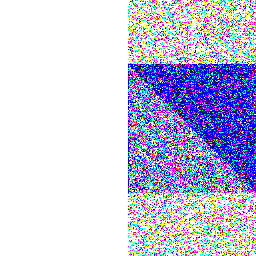

In [41]:
numpy_to_pil(modified_image.detach().numpy())

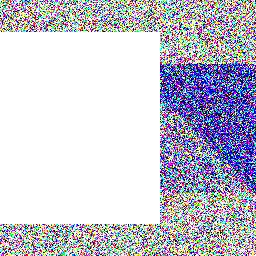

In [42]:
numpy_to_pil(ret_images[model_size][0])

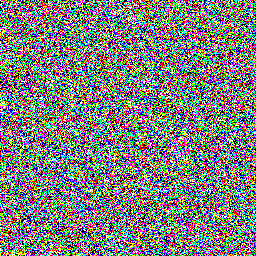

In [43]:
pil_image = numpy_to_pil(linear_1_weights[adversarial_1_max].detach().numpy())
display(pil_image)

In [44]:
run_joint_model(models_by_size[model_size],torch.stack([linear_1_weights[adversarial_1_max]]))

(tensor([[-0.1958,  0.5519]], grad_fn=<AddmmBackward0>),
 tensor([[3.7534],
         [1.0363]], grad_fn=<SqueezeBackward1>))

In [45]:
modified_image = deepcopy(linear_1_weights[torch.argmax(product_1[2])])
modified_image[:,:,:128] = torch.Tensor([0.25,0.25,0.25]).repeat((256,128)).reshape((3,256,128))
run_joint_model(models_by_size[model_size],torch.stack([modified_image]))

(tensor([[-1.7613,  1.9889]], grad_fn=<AddmmBackward0>),
 tensor([[33.9446],
         [-5.6979]], grad_fn=<SqueezeBackward1>))

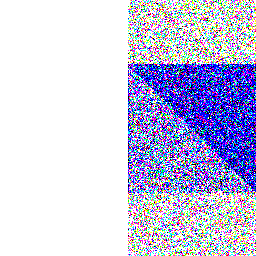

In [46]:
numpy_to_pil(modified_image.detach().numpy())

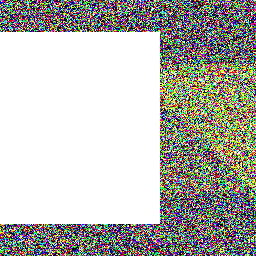

In [47]:
numpy_to_pil(ret_images[model_size][1])

## Filter Pruning

In [14]:
def run_model(remove_filters,model,x):
    x = x.view(x.shape[0],3*model.first_model.input_image_size**2)
    counter = 0

    for i in model.first_model.linear_layers:
        x = i(x) 
        if counter == 0:
            x[:,remove_filters] = 0

        counter += 1
    return x

In [15]:
def model_accuracy(remove_filters,model,x,y):
    output = run_model(remove_filters,model,x)
    output = torch.nn.Sigmoid()(output)
    num_right = torch.sum(torch.clip(torch.round(output),0,1) == y).item()
    return num_right/torch.numel(output)

In [85]:
model_accuracy([],models_by_size[model_size],val_images,val_c)

1.0

In [89]:
biggest_filter_0_adversarial = torch.argmax(product_0[1]-product_0[0]).item()
biggest_filter_1_adversarial = torch.argmax(product_1[3]-product_1[2]).item()

In [92]:
to_remove = list(set([biggest_filter_0_adversarial,biggest_filter_1_adversarial]))

In [93]:
model_accuracy(to_remove,models_by_size[model_size],val_images,val_c)

0.5234375

In [12]:
def run_model_as_function(remove_filters):
    return lambda m, x: (run_model(remove_filters,m,x), run_model(remove_filters,m,x).T)

In [96]:
run_model_as_function([])(models_by_size[model_size],val_images)

tensor([[ 47.8834, -13.7593],
        [-30.5177,  84.4437],
        [ 47.8834, -13.7593],
        [-30.8157,  83.5655],
        [-30.8157,  83.5655],
        [ 47.8834, -13.7593],
        [-30.8157,  83.5655],
        [-30.5177,  84.4437],
        [-30.8157,  83.5655],
        [ 47.8834, -13.7593],
        [ 47.8834, -13.7593],
        [-30.8157,  83.5655],
        [ 47.8834, -13.7593],
        [ 48.1536, -12.7792],
        [ 47.8834, -13.7593],
        [ 48.1536, -12.7792],
        [-30.8157,  83.5655],
        [ 47.8834, -13.7593],
        [-30.8157,  83.5655],
        [ 47.8834, -13.7593],
        [-30.8157,  83.5655],
        [ 48.1536, -12.7792],
        [ 47.8834, -13.7593],
        [ 47.8834, -13.7593],
        [-30.5177,  84.4437],
        [ 48.1536, -12.7792],
        [-30.8157,  83.5655],
        [-30.5177,  84.4437],
        [ 48.1536, -12.7792],
        [-30.5177,  84.4437],
        [-30.8157,  83.5655],
        [ 48.1536, -12.7792],
        [-30.5177,  84.4437],
        [ 

In [104]:
ret_image = get_maximal_activation(models_by_size[model_size],run_joint_model,0,
                                        get_valid_image_function(0,num_objects,epsilon=32))
torch.nn.Sigmoid()(run_joint_model(models_by_size[model_size],ret_image)[1])[concept_num][0].detach().numpy()

array(0., dtype=float32)

In [110]:
run_joint_model(models_by_size[model_size],val_images)[1].shape

torch.Size([2, 128])

In [112]:
(models_by_size[model_size],val_images)[1] == run_joint_model(models_by_size[model_size],val_images)[1]

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, 

In [30]:
info_by_model_size = {}

for model_size in [2,5,10,15]:
    print("On model size {}".format(model_size))

    filter_accuracies = []
    filter_adversarialness = []

    for filter_num in range(model_size):
        for seed in [42,43,44]:
            remove_filters = [filter_num]
            num_objects = 1
            noisy=False
            weight_decay = 0.0004
            encoder_model='mlp_{}_1'.format(model_size)
            optimizer = 'sgd'

            activations = []

            for concept_num in [0,1]:
                model = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

                ret_image = get_maximal_activation(models_by_size[model_size],run_model_as_function(remove_filters),concept_num,
                                                        get_valid_image_function(concept_num,num_objects,epsilon=32))
                activation_concept = torch.nn.Sigmoid()(run_joint_model(models_by_size[model_size],ret_image)[1])[concept_num][0].detach().numpy()
                activations.append(activation_concept)

            accuracy = model_accuracy(remove_filters,models_by_size[model_size],val_images,val_c)
            filter_accuracies.append(accuracy)
            filter_adversarialness.append(activations)

    filter_adversarialness = np.array(filter_adversarialness)
    filter_accuracies = np.array(filter_accuracies)

    filter_adversarialness = filter_adversarialness.reshape((model_size,3,2))
    filter_accuracies = filter_accuracies.reshape((model_size,3))

    filter_adversarialness_mean = filter_adversarialness.mean(axis=1)
    filter_accuracies_mean = filter_accuracies.mean(axis=1)

    filter_adversarialness_std = filter_adversarialness.std(axis=1)
    filter_accuracies_std = filter_accuracies.std(axis=1)

    info_by_model_size[model_size] = {
        'adversarialness': [filter_adversarialness_mean.tolist(),filter_adversarialness_std.tolist()], 
        'accuracies': [filter_accuracies_mean.tolist(),filter_accuracies_std.tolist()]
    }

On model size 2
On model size 5
On model size 10
On model size 15


In [31]:
json.dump(info_by_model_size,open("results/ablation/mlp_filter_ablation.json","w"))